# Group 9 - Analysing the Results of Metaheuristics Tacking the TSP

* Olukayode Martins (marti196)
* Matthew Cheung (cheun227)
* Robert Green (greenr27)
* Humza Shahid (shahidh7)


[https://github.coventry.ac.uk/380CT-2021/Group-........](https://github.coventry.ac.uk/380CT-2021/Group-........)

# 1) Notation and definitions

Let $G$ be a [complete]( "graph is undirected, has no self-loops, and each node is connected to all the other vertices")  [weighted]( "the edges have a weight (a positive integer)") graph with $n$ vertices.

**Optimisation TSP**:
> Given $G$, find a cycle of minimal total cost.

This problem is **NP-Hard** because its decision version is **NP-complete** (Garey and Johnson, 1979, p. 211).

# 2) Testing methodology

```
.................................................................
.................................................................
...  You can add or improve this section and its subsections  ...
.................................................................
.................................................................
```

* **Exact method (Exhaustive search)**:
    Average _time_ for instances with increasing $n$.

* **Greedy and meta-heuristics**:
    Average _time_ and _"quality"_ as $n$ increases.

Instances will be generated randomly as shown in the next subsection.

## 2.1) Random instances sampling strategy

Four types of TSP instances will be generated by creating an **adjacency matrices** $M$ as follows:
1. **Asymmetric**: The edge weights are independent and uniformly random in an interval $[1,\text{MAX_WEIGHT}]$, i.e the graph is assumed to be directed.
2. **Symmetric**: Like the asymmetric case but the graph is undirected, and the matrix is therefore symmetric: $M_{ij}=M_{ji}$.
3. **Euclidean**: Generate points using $(x,y)$ coordinates, then generate the adjacency matrix by calculating all the required distances. Recall that the distance between two points $(x_1,y_1)$ and $(x_2,y_2)$ is $\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$. The points are generated in the rectangle defined by the points $(0,0)$ and $(\text{MAX_Y},\text{MAX_Y})$.
4. **Graphs with obvious shortest cycle**: A graph where all the distances are 2 except for the edges on a predefined cycle, where the distance is 1. Such a graph would be useful for testing/debugging the "nearest neighbour greedy" search.

### Implementation of the instances generation

First start by importing relevant libraries.

In [1]:
from random import randint, shuffle # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from itertools import chain # concatenate range()'s'
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
import copy # to copy an object so it can be modified while preserving the original
sns.set_style("white")

from math import exp #returning exponentials (used for simulated annealing)
import random #getting probability (used for simulated annealing)

### Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

For simplicity, we will consider $0$ to be the start and end point of cycles.

In [2]:
class Graph:
    ''' Random graphs '''
    def __init__(self, n=0, type='asymmetric', MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if   type=='symmetric': self.__random_symmetric_graph(n,MAX_WEIGHT)
        elif type=='Euclidean': self.__random_euclidean_graph(n,MAX_X,MAX_Y)
        elif type=='easy':      self.__random_cycle_graph(n)
        else:                   self.__random_asymmetric_graph(n,MAX_WEIGHT) # assume 'asymmetric' otherwise
            
    def __getitem__(self, i):
        ''' Allow indexing to get the weights '''
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self,n, MAX_WEIGHT):
        ''' Asymmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(n):
                if i==j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1,MAX_WEIGHT)

    def __random_symmetric_graph(self,n,MAX_WEIGHT):
        ''' Symmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(i+1,n):
                w = randint(1,MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        ''' Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) '''
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1,n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a,b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self,n,MAX_X,MAX_Y):
        ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points)<n: # We may get duplicate (x,y) so we try until we get enough points
            x,y = randint(0,MAX_X), randint(0,MAX_Y)
            points.add((x,y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1,n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points=points

In [3]:
def cost(G, cycle):
    ''' Calculate the cost of the given cycle [0,...,0] in G '''
    return sum(G[a][b] for a,b in zip(cycle, cycle[1:]))

Functions to show the graphs as **adjacency matrices** or as a **drawing**:

In [4]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    for a in G.vertices:
        for b in G.vertices:
            if a==b: continue # no self-loops
            nxG.add_edge(a, b, weight=G[a][b])        
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary, label_pos=0.5 if G.type!="asymmetric" else 0.25)

## 3) Nearest Neigbour Greedy method

#### Idea

Start at city 0, move to the nearest city, then from there to the next nearest city, and so on, until all cities are visited. Finally, return back to the start city.

#### Pseudocode

1. $city \gets 0$
2. $visited\gets []$
3. **while** not all cities are visited **do**
4. $\quad$ $nearest\_city \gets \text{nearest city to $city$ that has not been visited yet}$
5. $\quad$ Append $city$ to $visited$ $\qquad\qquad\text{(i.e. mark $city$ as visited)}$
5. $\quad$ $city\gets nearest\_city$
6. **end while**
8. **return** $visited$

#### Running time analysis

The while-loop costs $O(n)$, and searching for the nearest city on line 4 costs $O(n)$ also, while the rest can be assumed to cost $O(1)$.
So the total cost of this greedy approach is therefore $O(n)\times O(n) = O(n^2)$.

#### Implementation

In [5]:
def greedy_nearest_neighbour(G):
    ''' Returns best found cycle and its cost '''
    unvisited = G.vertices.copy()
    visited = [] # solution to be built
    city = 0 # Start city
    while len(unvisited)>0:
        # Find nearest neighbour
        nearest_city = None
        shortest_distance = oo
        for neighbour in unvisited:
            if G[city][neighbour] < shortest_distance:
                shortest_distance = G[city][neighbour]
                nearest_city = neighbour
        # Update 'cycle' and 'cities' and G then 'city'
        visited.append(city)
        unvisited.remove(city)
        city = nearest_city
    return (visited, cost(G, visited+[0]))

# 4) Metaheuristics

```
............................................................
............................................................

Meta-heuristic 1
- Explanation/Idea/Skeleton
- High-levle pseudocode
- Big-O analysis of time (and space if deemed significant/useful)
- Implementation
- Experiments on time & quality (vs greedy) for graphs with up to 100's of vertices (Choose 1 or multiple graph topologies)

............................................................
............................................................

Ditto for Meta-heuristic 2

............................................................
............................................................

* You may have the experiments combined for both meta-heuristics in one place if you prefer. Either way is acceptable.
* Either way you should consider having the 2 meta-heuristics compared against each other (to be able to make a recommendation in the conclusion).

............................................................
............................................................

- Conclusion (Based on your theoretical analysis and experimental findings, give clear and precise practical recommendations on which methods to use given the size and/or structure of the graph.)

............................................................
............................................................

- List of references

............................................................
............................................................
```

## Two-Opt Local Search
Two-Opt is a local search method used to gradually improve an existing tour. The idea is to exhange 2 edges with 2 other edges. This can cause crosses in paths, or even remove crosses in paths. This is used to reach a better tour (smaller cost). The downside of this method is that it can reach local optimum. 

#### Two-Opt Pseudocode

1. $shortest\_cycle \gets \text{current cycle from graph}$
2. $shortest\_distance \gets \text{distance of current cycle}$
2. **while** no shorter cycle found or all vertices searched **do**
3. $\quad$ $cycle \gets \text{new $cycle$ with two vertices swapped}$
5. $\quad$ $distance \gets \text{cost of new $cycle$}$
2. $\quad$ **if** $distance<shortest_distance$ **then**
7. $\qquad$ $shortest\_distance \gets distance$
7. $\qquad$ $shortest\_cycle \gets cycle$
4. $\quad$ **end if**
6. **end while**
7. **return** $shortest\_cycle$

#### Big-O Running Time Analysis

The while loop will cost $O(n)$ and searching through all edges will also cost $O(n)$. The rest of the algorithm are constant, so can be assumed to cost $O(1)$. The total cost of the 2-opt method (in terms of time) will cost $O(n) \times O(n) = O(n^2)$

#### Implementation 

5x5 easy graph:


,0,1,2,3,4
0,2,2,1,2,1
1,2,2,2,1,1
2,1,2,2,1,2
3,2,1,1,2,2
4,1,1,2,2,2


order:  [0, 1, 2, 3, 4]
Total Cost:  7


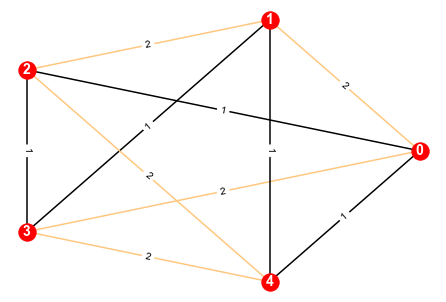

In [6]:
def twooptswap(G, i, j):
    '''Swap two vertices with each other and return new order as list'''
    route = G.vertices.copy()
    
    first = route[0:i] #get first part of cycle, before i
    mid = route[i:j] #get middle part of cycle
    rev = mid[::-1] #reverse middle part of cycle
    final = route[j:] #get final part of cycle
        
    #append middle (reversed) + final to first list to construct new cycle
    first.extend(rev)
    first.extend(final)
    
    #return new cycle
    return first
    
def twoopt(G):
    '''Keep swapping vertices until nodes exhausted or a shorter cycle is found'''
    shortest_cycle = G.vertices.copy() #store initial cycle
    shortest_distance = cost(G, shortest_cycle) #store distance of start cycle
    
    for i in range(len(shortest_cycle)): #for each vertex
        for j in range(len(shortest_cycle)): #for each vertex again
            if j <= i: #skip current (cannot swap with self) and previous vertices (already considered)
                continue
                
            cycle = twooptswap(G, i, j) #swap two nodes
            distance = cost(G, cycle) #calculate cost of new cycle
            
            #return new cycle/distance if shorter than previous
            if shortest_distance > distance:
                shortest_cycle = cycle
                shortest_distance = distance
                return shortest_cycle        
    
G = Graph(5,'easy')
show(G)
draw(G)
print('order: ', G.vertices)
print('Total Cost: ', cost(G, G.vertices.copy()))

5x5 easy graph:


,0,1,2,3,4
0,2,2,1,2,1
1,2,2,2,1,1
2,1,2,2,1,2
3,2,1,1,2,2
4,1,1,2,2,2


order:  [1, 0, 2, 3, 4]
Total Cost: 6


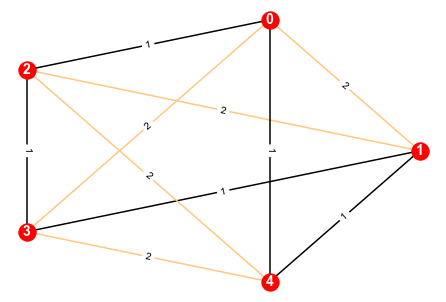

In [7]:
#copy the previous graph into a new object,
#perform two opt on new graph and draw
new_graph = copy.deepcopy(G)
new_cycle = twoopt(new_graph)
new_graph.vertices = new_cycle
show(new_graph)
draw(new_graph)
print('order: ', new_cycle)
print('Total Cost:' , cost(new_graph, new_cycle))



## Simulated Annealing 

### Introduction to Simulated Annealing
Simulated annealing, is an **approximation method to optimise a path from a search area.** Iteratively swaps neighbours to form new paths. If the new path cost is less than the current path cost, it accepts the new path and continues the iteration process. Otherwise, the algorithm runs an acceptance probability criterion function to see if the new (and worse) path will be accepted. The probability will depend on the temperature and the “height” between the new and current paths.
With each iteration, the temperature decreases until T(temperature) equals 0. The lower the temperature, the lower the probability of accepting a worse path. This is usually referred to as the annealing schedule (like the cooling schedule of annealing regarding heat treatment). The bigger the height (meaning the bigger the difference between the new and current path), the less likely the function is to accept the new path.

Simulated annealing accepts better results for each iteration to find an optimum (in this case, the smallest cost) but is also aware that it can reach the local optimum. **It will sometimes accept worse paths to investigate other local search areas and hopefully find the global optimum.**

### Algorithm: Simulated Annealing Pseudocode 
**Input:** A cycle of edges, with a weight when connecting to all other edges, an initial temperature, and a change determining the decrease in temperature over time.<br>**Output:** The smallest cost of the cycle and the cycle order.

1. $new\_solution \gets \text{current cycle from graph}$
2. $final\_solution \gets new\_solution$
3. $temperature \gets \text{temperature from input}$
4. $final\_temperature \gets \text{0}$
5. $temp\_decrement \gets \text{change from input}$
6. **while** $final\_temperature < temperature$ **do**
7. $\quad$ $\text{generate new neighbour for} new\_solution$
8. $\quad$ $cost_difference \gets new\_solution\_cost - final\_solution\_cost$
9. $\quad$ **if** $cost_difference < 0$ **then** 
10. $\qquad$ $final\_solution \gets new\_solution$
11. $\quad$ **else if** $rand(0,1) < exp(cost_difference / temperature)$ **then**
12. $\qquad$ $final\_solution \gets new\_solution$
13. $\quad$ **end if**
13. $\quad$ $temperature \gets temperature - temp\_decrement$
14. **end while**
15. **return** $final\_solution$

### Simulated Annealing: Big-O Analysis

The while loop will cost $O(n)$ while the rest of the algorithm is constant, so it can be assumed to cost $O(1)$. The total cost for the Simulated Annealing algorithm (in terms of time) costs $O(n)$.

### Implementation of Simulated Annealing

In [8]:
def simulatedAnnealing(G, initialTemperature, change):
    '''search for better cycles while periodically accepting worse cycles to explore
        as many local search areas to find the shortest cycle'''
    #solutions function like states(in this case, being a set order of the cycle)
    newSolution = G.vertices.copy() #also known as current state
    finalSolution = newSolution #plays the role as the shortest cycle
    temperature = initialTemperature
    finalTemperature = 0 #function stops once temperature reaches this number
    tempDecrement = change 
    
    while finalTemperature < temperature:
        newSolution = twooptAlt(G) #generate a new cycle via 2-opt local search method
        costDifference = (cost(G, newSolution) - cost(G, finalSolution))
        #print('cost difference: ', costDifference)
        #if the new cycle has a lower cost, accept as "final" solution,
        #otherwise test with acceptance criteron 
        if costDifference < 0:
            finalSolution = newSolution
            #print('Accepted!')
            #print('new solution: ', finalSolution)
            #print('new cost: ', cost(G, finalSolution))
        elif acceptanceProbability(costDifference, temperature):
            finalSolution = newSolution
            #print('Accepted!')
            #print('new solution: ', finalSolution)
            #print('new cost: ', cost(G, finalSolution))
        
        temperature -= tempDecrement #decrement temperature in accordance to annealing/cooling schedule
        
    return finalSolution

def acceptanceProbability(costDifference, temp):
    '''Acceptance probability criteron to decide whether to accept a worse cycle or not'''
    rnd = random.uniform(0,1)
    criterion = exp(-costDifference / temp)
    #print(rnd, ', ', critereon)
    if rnd < criterion:
        return True #accept cycle
    else:
        return False #reject cycle
    
def twooptAlt(G):
    '''Alternative version of 2-Opt method. Will return a new cycle regardless of the cost
        being smaller or not'''
    shortest_cycle = G.vertices.copy() #store initial cycle
    shortest_distance = cost(G, shortest_cycle) #store distance of start cycle
    
    i = random.randint(0, (len(G.vertices)-1))
    j = random.randint(0, (len(G.vertices)-1))

    new_cycle = twooptswap(G, i, j) #swap two nodes
    new_distance = cost(G, new_cycle) #calculate cost of new cycle

    shortest_cycle = new_cycle
    shortest_distance = new_distance
    return shortest_cycle

### Simulated Annealing: Time & Quality Experiments

10x10 symmetric graph:


,0,1,2,3,4,5,6,7,8,9
0,inf,59.0,84.0,1.0,89.0,42.0,77.0,19.0,42.0,97.0
1,59.0,inf,21.0,90.0,42.0,35.0,75.0,45.0,28.0,86.0
2,84.0,21.0,inf,48.0,41.0,96.0,92.0,53.0,36.0,91.0
3,1.0,90.0,48.0,inf,65.0,51.0,20.0,89.0,57.0,37.0
4,89.0,42.0,41.0,65.0,inf,55.0,1.0,88.0,24.0,54.0
5,42.0,35.0,96.0,51.0,55.0,inf,82.0,50.0,60.0,56.0
6,77.0,75.0,92.0,20.0,1.0,82.0,inf,36.0,89.0,7.0
7,19.0,45.0,53.0,89.0,88.0,50.0,36.0,inf,41.0,71.0
8,42.0,28.0,36.0,57.0,24.0,60.0,89.0,41.0,inf,84.0
9,97.0,86.0,91.0,37.0,54.0,56.0,7.0,71.0,84.0,inf


order:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total Cost:  491


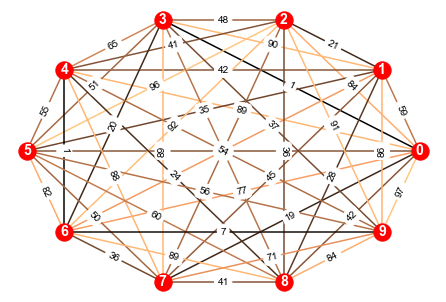

In [9]:
saGraph = Graph(10, 'symmetric')
show(saGraph)
draw(saGraph)
print('order: ', saGraph.vertices)
print('Total Cost: ', cost(saGraph, saGraph.vertices.copy()))

10x10 symmetric graph:


,0,1,2,3,4,5,6,7,8,9
0,inf,59.0,84.0,1.0,89.0,42.0,77.0,19.0,42.0,97.0
1,59.0,inf,21.0,90.0,42.0,35.0,75.0,45.0,28.0,86.0
2,84.0,21.0,inf,48.0,41.0,96.0,92.0,53.0,36.0,91.0
3,1.0,90.0,48.0,inf,65.0,51.0,20.0,89.0,57.0,37.0
4,89.0,42.0,41.0,65.0,inf,55.0,1.0,88.0,24.0,54.0
5,42.0,35.0,96.0,51.0,55.0,inf,82.0,50.0,60.0,56.0
6,77.0,75.0,92.0,20.0,1.0,82.0,inf,36.0,89.0,7.0
7,19.0,45.0,53.0,89.0,88.0,50.0,36.0,inf,41.0,71.0
8,42.0,28.0,36.0,57.0,24.0,60.0,89.0,41.0,inf,84.0
9,97.0,86.0,91.0,37.0,54.0,56.0,7.0,71.0,84.0,inf


order:  [0, 1, 2, 3, 4, 5, 8, 7, 6, 9]
Total Cost:  392


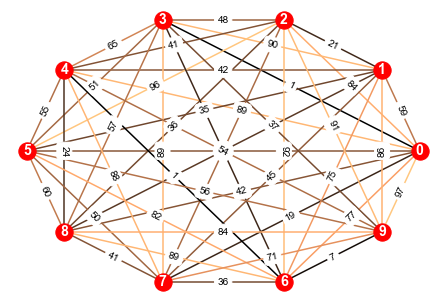

In [10]:
#demonstrating SA annealing to the graph above
newGraph = copy.deepcopy(saGraph)
newCycle = simulatedAnnealing(newGraph, 300, 1)
newGraph.vertices = newCycle
show(newGraph)
draw(newGraph)
print('order: ', newCycle)
print('Total Cost: ', cost(newGraph, newCycle))

#### Test Plan (Provisional)
The assignment brief advises students to use graphs "graphs with hundreds if not thousands of vertices" for measuring time and quality. Provisionally, it is proposed to generate graphs of each type (symmetric, asymettric and Euclidean) to test an equal number of graphs with hundreds and thousands of vertices, where the number of vertices are selected from the set: $n = \{300, 600, 900, 1200, 1500, 1800\}$.

In [11]:
def sa_stats(num_vertices, num_tests, graph_type='asymmetric'):
    '''Perform SA on graphs with a given number over vertices, a given number of times,
    and return (a) mean time elapsed and (b) mean reduction in cost'''
    
    # Initialise lists for calculating mean
    time_list = []
    cost_list = []
    
    # Loop that:
    # 1. Generates a graph of input type with input number of vertices
    # 2. Records cost of start cycle, and the current time before SA is performed
    # 3. Performs SA
    # 4. Records current time after SA is performed, and then record cost of new cycle
    # 5. Calculates elapsed time and difference in cost, and append these values to list
    for loop in range(num_tests):
        G = Graph(num_vertices, graph_type) # Generate graph of type
        old_cycle = G.vertices.copy() # Copy initial cycle
        start_cost = cost(G, old_cycle) # Record cost at start
        before_sa = perf_counter() # Record time immediately before SA
        new_cycle = simulatedAnnealing(G, 300, 1) # Perform SA
        after_sa = perf_counter() # Record time immediately after SA
        end_cost = cost(G, new_cycle) # Record cost of newly found cycle
        elapsed = after_sa - before_sa # Calculate time SA function has taken in seconds
        time_list.append(elapsed) # Append elapsed time to list
        cost_difference = (start_cost - end_cost) / start_cost # Calculate difference in cost
        cost_list.append(cost_difference) # Append cost difference to list
    
    return time_list, cost_list

In [12]:
# BE CAREFUL. THIS TAKES A VERY LONG TIME TO PROCESS WITH OUR TEST CASES

def createTestData(graph_list, max_reps, graph_type='asymmetric'):
    '''Given an array of edge lengths (integer) and the number of test repititions, returns a table 
        containing computation time and difference in cost (before and after) for each edge length'''
    i = 0
    data_table = pd.DataFrame(columns=['edge count (n)', 'Time (seconds)', 'Cost difference in percent (%)'])
    for graph_number in graph_list:
        graph_time_list, graph_cost_list = sa_stats(graph_number, max_reps, graph_type) #generates stats for test
        for j in range(0, max_reps): #adds data to table
            data_table.loc[i] = [graph_number, graph_time_list[j], graph_cost_list[j]]
            i += 1
    #calculates min, max, mean value and standard deviation for each set of data
    return data_table.groupby('edge count (n)').agg(['min','max','mean','std'])

In [13]:
createTestData([300,600,900,1200,1500,1800],200) # Produce stats table for asymmetric graphs

Time (seconds)                                \
                          min       max      mean       std   
edge count (n)                                                
300.0                0.060839  0.096022  0.066945  0.004396   
600.0                0.122729  0.526845  0.139186  0.032701   
900.0                0.188112  0.677774  0.242811  0.083492   
1200.0               0.249454  0.833261  0.312724  0.073141   
1500.0               0.315670  1.119654  0.363636  0.078509   
1800.0               0.397384  1.208465  0.436635  0.062376   

               Cost difference in percent (%)                                
                                          min       max      mean       std  
edge count (n)                                                               
300.0                                0.004894  0.126705  0.040809  0.021045  
600.0                                0.001760  0.077158  0.028679  0.014135  
900.0                                0.002557  0.070576  0.024738  0.013168  
1200.0                               0.002334  0.066277  0.020805  0.012094  
1500.0                               0.001358  0.061184  0.020156  0.010981  
1800.0                               0.002385  0.051243  0.018309  0.009393

In [14]:
createTestData([300,600,900,1200,1500,1800],200, 'symmetric') # Produce stats table for symmetric graphs

Time (seconds)                                \
                          min       max      mean       std   
edge count (n)                                                
300.0                0.064426  0.139262  0.068346  0.008560   
600.0                0.128132  0.157731  0.135298  0.004645   
900.0                0.186933  0.441728  0.208238  0.024442   
1200.0               0.250791  0.772268  0.290545  0.053136   
1500.0               0.326950  0.480686  0.351244  0.015949   
1800.0               0.383497  1.473172  0.472969  0.119112   

               Cost difference in percent (%)                                
                                          min       max      mean       std  
edge count (n)                                                               
300.0                               -0.001231  0.010975  0.006815  0.002067  
600.0                                0.000569  0.005673  0.003437  0.001019  
900.0                                0.000583  0.003923  0.002301  0.000702  
1200.0                               0.000583  0.002828  0.001717  0.000477  
1500.0                               0.000354  0.002462  0.001396  0.000416  
1800.0                               0.000329  0.002042  0.001184  0.000337

In [13]:
createTestData([300,600,900,1200,1500,1800],200, 'Euclidean') # Produce stats table for Euclidean graphs

Time (seconds)                                \
                          min       max      mean       std   
edge count (n)                                                
300.0                0.070870  0.303994  0.106692  0.039655   
600.0                0.145500  0.677689  0.200706  0.063042   
900.0                0.222318  0.631563  0.287781  0.046744   
1200.0               0.314681  1.483506  0.479677  0.192875   
1500.0               0.367500  2.412438  0.532010  0.217877   
1800.0               0.447348  1.446427  0.552976  0.130536   

               Cost difference in percent (%)                                
                                          min       max      mean       std  
edge count (n)                                                               
300.0                                0.001221  0.011592  0.006340  0.001989  
600.0                                0.001088  0.005961  0.003139  0.000965  
900.0                                0.000582  0.004557  0.002109  0.000651  
1200.0                               0.000413  0.002954  0.001569  0.000485  
1500.0                               0.000480  0.002312  0.001271  0.000388  
1800.0                               0.000170  0.002257  0.001048  0.000334

## References

- https://www.researchgate.net/publication/6026283_Optimization_by_Simulated_Annealing
- Croes, G. (1958). A Method for Solving Traveling-Salesman Problems. Operations Research, 6(6), 791-812. Retrieved March 25, 2021, from http://www.jstor.org/stable/167074
- Sathyan, A., Boone, N. and Cohen, C. (2015).Comparison of Approximate Approaches to Solving the Travelling Salesman Problem and its Application to UAV Swarming. Retrieved March 25 2021, from https://www.researchgate.net/publication/268981882_Comparison_of_Approximate_Approaches_to_Solving_the_Travelling_Salesman_Problem_and_its_Application_to_UAV_Swarming **(page 6)**